# HW 5
## Recommendation Systems

## Part 1: Pyspark (40 Points)

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [190]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

Now we authenticate a Google Drive client to download the filea we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1QtPy_HuIMSzhtYllT3-WeM3Sqg55wK_D'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('MovieLens.training')

id='1ePqnsQTJRRvQcBoF2EhoPU8CU1i5byHK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('MovieLens.test')

id='1ncUBWdI5AIt3FDUJokbMqpHD2knd5ebp'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('MovieLens.item')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, we import some of the common libraries needed for our task.

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [276]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

### Data Loading

In this Colab, we will be using the [MovieLens dataset](https://grouplens.org/datasets/movielens/), specifically the 100K dataset (which contains in total 100,000 ratings from 1000 users on ~1700 movies).

We load the ratings data in a 80%-20% ```training```/```test``` split, while the ```items``` dataframe contains the movie titles associated to the item identifiers.

In [277]:
schema_ratings = StructType([
    StructField("user_id", IntegerType(), False),
    StructField("item_id", IntegerType(), False),
    StructField("rating", IntegerType(), False),
    StructField("timestamp", IntegerType(), False)])

schema_items = StructType([
    StructField("item_id", IntegerType(), False),
    StructField("movie", StringType(), False)])

training = spark.read.option("sep", "\t").csv("MovieLens.training", header=False, schema=schema_ratings)
test = spark.read.option("sep", "\t").csv("MovieLens.test", header=False, schema=schema_ratings)
items = spark.read.option("sep", "|").csv("MovieLens.item", header=False, schema=schema_items)

In [278]:
training.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)



In [279]:
items.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- movie: string (nullable = true)



### Your task

Let's compute some stats!  What is the number of ratings in the training and test dataset? How many movies are in our dataset?

In [280]:
#Count the number of ratings 
training.count()

80000

In [281]:
test.count()

20000

In [282]:
items.count()

1682

Using the training set, train a model with the Alternating Least Squares method available in the Spark MLlib: [https://spark.apache.org/docs/latest/ml-collaborative-filtering.html](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html)

maxIter = 5, regParam=0.01

In [283]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [284]:
# YOUR CODE HERE
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")

In [285]:
model = als.fit(training)

Now compute the RMSE on the test dataset.


In [286]:
#First we will have to make rpedictions for the test set
predictions = model.transform(test)


In [287]:
predictions.show(5)

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    148|      1|     4|877019411|  4.228874|
|    148|      7|     5|877017054| 3.5808556|
|    148|     70|     5|877021271| 2.0453598|
|    148|     71|     5|877019251|   3.86548|
|    148|     78|     1|877399018| 2.6410918|
+-------+-------+------+---------+----------+
only showing top 5 rows



In [288]:
#Now we set up the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [289]:
#And finally we compute the RMSE
rsme = evaluator.evaluate(predictions)

In [207]:
rsme

1.1281907515250782

The RSME on the test dataset is 1.1281907515250782

At this point, you can use the trained model to produce the top-K recommendations for each user.  Recommend the top three movies for each user. 

In [290]:
userRecs = model.recommendForAllUsers(3)

/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [294]:
# show the first userid and the first three recommendations
first_user_d =  userRecs.toPandas().head(1)

In [305]:
print("These are the recommendations for the first user:")
for item in first_user_d['recommendations'].head(3)[0]:
    print(items.filter(items.item_id == item['item_id']).select("movie").collect()[0]['movie'])

These are the recommendations for the first user:
Angel Baby (1995)
Shall We Dance? (1937)
Boys of St. Vincent, The (1993)


Print the name of the movies recommended for user 444  

In [216]:
#First we get the top 3 recommendations for the 444 user
reccomendation = userRecs.filter(userRecs.user_id == 444)

In [217]:
reccomendation

DataFrame[user_id: int, recommendations: array<struct<item_id:int,rating:float>>]

In [218]:
#get list of movies for the 444 user
temp = reccomendation.collect()

In [219]:
ls = [items.filter(items.item_id == i['item_id']).select('movie').collect()[0][0] for i in temp[0][1]]

In [307]:
print("These are the recommendations for the 444 user :" )
for i in ls:
    print(i)

These are the recommendations for the 444 user :
Beautiful Thing (1996)
Ruby in Paradise (1993)
Higher Learning (1995)


## Part 2: Collaborative Filtering (60 Points)

scikit-surprise(http://surpriselib.com/) is a good library for multiple recommender systems algorithms. <br>You may start playing around with wrapper functions from the link provided.

Hint: Transform pyspark dataframe into pandas dataframe

In [137]:
# install surprise to build recommender in python
!pip install scikit-surprise

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 2.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp39-cp39-macosx_12_0_arm64.whl size=751294 sha256=bc5407699fb192f0c83076381835a88e5c2855a0cc2336e02ed553fa7b53481c
  Stored in directory: /Users/virenmanojparmar/Library/Caches/pip/wheels/6b/10/c9/7f607c8cb522ef378844f41e63b30d7181a6495d2c1ae514e9
Successfully built scikit-surprise
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/7

### Task. Memory-based Filtering 

Your task is to train a predictor using the `training` set provided above, and make predictions on the `test` set.

A. User-based recommendation

To make a prediction on user $u$'s rating on item $i$ ($R_{u, i}$), User-based recommendation finds the top-N user neighbors who have already completed rating on $i$, taking their average (unweighted or weighted by their similarity with $u$) as the prediction $\hat{R}_{u,i}$.


(1). Use default parameters, report *RMSE* on training & test set, respectively.

In [308]:
from surprise import KNNWithMeans
from surprise import Reader
from surprise import Dataset
import math

In [309]:
trainingPd = training.toPandas()
testPd = test.toPandas()
itemsPd = items.toPandas()

In [310]:
reader = Reader(rating_scale=(1,5))

In [311]:
trainingPd.drop(['timestamp'], axis=1, inplace=True)
testPd.drop(['timestamp'], axis=1, inplace=True)

In [312]:
# Your code here
traindata = Dataset.load_from_df(trainingPd[['user_id', 'item_id', 'rating']], reader)
testdata = Dataset.load_from_df(testPd[['user_id', 'item_id', 'rating']], reader)

In [313]:
train_Dataset = traindata.build_full_trainset()

In [314]:
model = KNNWithMeans(sim_options={'name': 'msd', 'user_based': True}, verbose=True)

In [315]:
model.fit(train_Dataset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [316]:
testset_from_train = [traindata.df.loc[i].to_list() for i in range(len(traindata.df))]

In [317]:
predictions = model.test(testset_from_train)

In [318]:
len(predictions)

80000

In [319]:
len(testset_from_train)

80000

Calculate RMSE of the actual ratings $R$ and the predicted ratings $\hat{R}$ in the training set.

In [320]:
# Your code here
sum = 0.0
for i,j in zip(testset_from_train, predictions):
    sum += (i[2] - j.est)**2
print("The RMDE for training set is ", math.sqrt(sum/len(testset_from_train)))

The RMDE for training set is  0.7569412498224154


Now let's make predictions on the test set

In [273]:
testset_from_test = [testdata.df.loc[i].to_list() for i in range(len(testdata.df))]

In [274]:
predictions_for_test_set =  model.test(testset_from_test)

Calculate RMSE of the actual ratings $R$ and the predicted ratings $\hat{R}$ from the trained user-based recommendation.

In [322]:
# Your code here
sum = 0.0
for i,j in zip(testset_from_test, predictions_for_test_set):
    sum += (i[2] - j.est)**2
print("The RMSE for the test set is: ", math.sqrt(sum/len(testset_from_test)))

The RMSE for the test set is:  0.9649111798953487


(2). Now display the top 10 movies for user 10, ranked by the predicted rating scores in the test set.

In [323]:
# Your code here
predictions_for_test_set_df = pd.DataFrame(predictions_for_test_set)

In [242]:
predictions_for_test_set_df.head

<bound method NDFrame.head of        uid   iid  r_ui       est                                    details
0        1     6     5  3.684493  {'actual_k': 20, 'was_impossible': False}
1        1    10     3  3.830113  {'actual_k': 40, 'was_impossible': False}
2        1    12     5  4.413642  {'actual_k': 40, 'was_impossible': False}
3        1    14     5  4.156297  {'actual_k': 40, 'was_impossible': False}
4        1    17     3  3.504539  {'actual_k': 40, 'was_impossible': False}
...    ...   ...   ...       ...                                        ...
19995  458   648     4  3.913156  {'actual_k': 40, 'was_impossible': False}
19996  458  1101     4  3.879986  {'actual_k': 40, 'was_impossible': False}
19997  459   934     3  2.853176  {'actual_k': 40, 'was_impossible': False}
19998  460    10     3  3.860369  {'actual_k': 40, 'was_impossible': False}
19999  462   682     5  3.711871  {'actual_k': 40, 'was_impossible': False}

[20000 rows x 5 columns]>

In [243]:
list_of_item_id = predictions_for_test_set_df[predictions_for_test_set_df['uid'] == 10].sort_values(by='est', ascending=False)[['iid']][:10]

In [244]:
movie_ls_user_10 = [items.filter(items.item_id == i).select('movie').collect()[0][0] for i in list_of_item_id['iid']]

In [325]:
print("These are the top 10 recommendations for user 10 using user based recommendation")
for i in movie_ls_user_10:
    print("\t",i)

These are the top 10 recommendations for user 10 using user based recommendation
	 Casablanca (1942)
	 Shawshank Redemption, The (1994)
	 Bridge on the River Kwai, The (1957)
	 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
	 Godfather, The (1972)
	 Silence of the Lambs, The (1991)
	 Secrets & Lies (1996)
	 Rear Window (1954)
	 Sunset Blvd. (1950)
	 Sense and Sensibility (1995)


(3). From what we learned in class, the number of nearest neighbors ($k$) considered for rating estimation $\hat{R}$ is an important hyperparameter affecting the prediction results. Repeat the training procedure above with different nearest neighbor selections (2-10), find the optimal $k$ in your experiment and report the corresponding *RMSE* in the test set.

In [326]:
# Your code here
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [327]:
RMSE = []
for k in k_values:
    print(k)
    modelk = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'msd', 'user_based': True}, verbose=True)
    modelk.fit(train_Dataset)
    predictionsk = modelk.test(testset_from_test)
    sum = 0.0
    for i,j in zip(testset_from_test, predictionsk):
        sum += (i[2] - j.est)**2
    print(sum)
    print(math.sqrt(sum/len(testset_from_test)))
    RMSE.append(math.sqrt(sum/len(testset_from_test)))
    

2
Computing the msd similarity matrix...
Done computing similarity matrix.
25313.730832503894
1.125027351500929
3
Computing the msd similarity matrix...
Done computing similarity matrix.
22947.339059578953
1.0711521614499724
4
Computing the msd similarity matrix...
Done computing similarity matrix.
21706.860919788192
1.041797987130619
5
Computing the msd similarity matrix...
Done computing similarity matrix.
20998.31789061568
1.0246540365073393
6
Computing the msd similarity matrix...
Done computing similarity matrix.
20518.669452052298
1.0128837409113718
7
Computing the msd similarity matrix...
Done computing similarity matrix.
20173.815842066248
1.0043359956226363
8
Computing the msd similarity matrix...
Done computing similarity matrix.
19894.406486848424
0.997356668570688
9
Computing the msd similarity matrix...
Done computing similarity matrix.
19695.312217956034
0.9923535715146098
10
Computing the msd similarity matrix...
Done computing similarity matrix.
19569.72776354551
0.9891

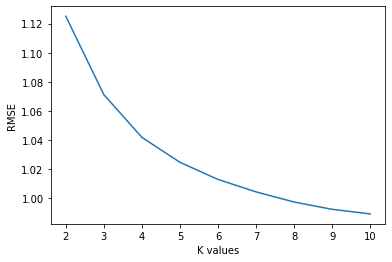

In [329]:
import matplotlib.pyplot as plt

plt.plot(k_values, RMSE)
plt.xlabel('K values')
plt.ylabel('RMSE')
plt.show()

Note that we can write a for-loop to iterate throuogh different choices, but scikit-surprise provides us with a simplified cross-validation interface (`surprise.model_selection.GridSearchCV`) to fine-tune such hyperparameter.


Report the optimal k value. 

Report the RMSE given the optimal k value

In [330]:
from surprise.model_selection import GridSearchCV

In [331]:
# Your code her
param_grid = {'k': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(traindata)
gs.best_score['rmse']



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

0.9874638702908748

In [332]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [333]:
results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k
0,1.130999,1.126768,1.133172,1.130313,0.002659,9,0.108797,0.021815,1.178684,0.289840,{'k': 2},2
1,1.074065,1.068652,1.074963,1.072560,0.002788,8,0.085819,0.008004,0.885326,0.033193,{'k': 3},3
2,1.045037,1.039769,1.044802,1.043203,0.002430,7,0.071118,0.004824,0.873810,0.074967,{'k': 4},4
3,1.024464,1.022514,1.026467,1.024482,0.001613,6,0.093042,0.008024,1.347110,0.152429,{'k': 5},5
4,1.011541,1.010857,1.014224,1.012207,0.001453,5,0.092125,0.020142,0.982558,0.020357,{'k': 6},6
5,1.003437,1.002611,1.005224,1.003757,0.001091,4,0.078542,0.010485,0.974679,0.065833,{'k': 7},7
6,0.996010,0.996398,0.998376,0.996928,0.001036,3,0.075819,0.002955,1.167220,0.246153,{'k': 8},8
7,0.990288,0.991521,0.993157,0.991656,0.001175,2,0.102795,0.031821,1.105970,0.111882,{'k': 9},9
8,0.986144,0.987058,0.989190,0.987464,0.001276,1,0.101006,0.013958,1.309583,0.295925,{'k': 10},10


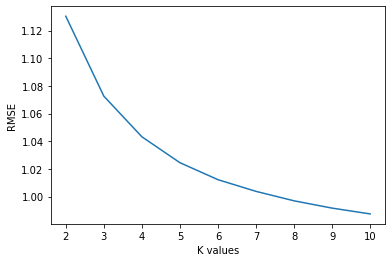

In [334]:
import matplotlib.pyplot as plt

plt.plot(k_values, results_df['mean_test_rmse'])
plt.xlabel('K values')
plt.ylabel('RMSE')
plt.show()

##### The Best RMSE score is 0.9874638702908748 for k=10 and we will use this value of k for item based recommendation

B. **item-based recommendation**

To make a prediction on user $u$'s rating on item $i$ ($R_{u, i}$), Item-based recommendation finds the top-N item neighbors (the user has rated) to $i$, taking their average (unweighted or weighted by their similarity with $i$) as the prediction $\hat{R}_{u,i}$.



(1). Similar to the previous question, implement the item-based recommender systems trained on the  `training` set, report the *RMSE* on both the `training` and `test` set. (Note: apply the optimal $k$ obtained in last question.)

In [253]:
model_item = KNNWithMeans(k=10, min_k=1, sim_options={'name': 'msd', 'user_based': False}, verbose=True)

In [254]:
model_item.fit(train_Dataset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [255]:
prediction_item_train = model_item.test(testset_from_train)

In [256]:
prediction_item_test =  model_item.test(testset_from_test)

In [335]:
# Your code here
sum = 0.0
for i,j in zip(testset_from_train, prediction_item_train):
    sum += (i[2] - j.est)**2
print("The RMSE from train set for item based recommmendations is:", math.sqrt(sum/len(testset_from_train)))

The RMSE from train set for item based recommmendations is: 0.5690496491977743


In [336]:
# Your code here
sum = 0.0
for i,j in zip(testset_from_test, prediction_item_test):
    sum += (i[2] - j.est)**2
print("The RMSE from test set for item based recommmendations is:", math.sqrt(sum/len(testset_from_test)))

The RMSE from test set for item based recommmendations is: 0.9783018562689111


(2). Similar to previous question, display the top 10 movies for user 10, ranked by the predicted rating scores in the test set.

In [337]:
predictions_for_test_set_df_i = pd.DataFrame(prediction_item_test)

In [338]:
list_of_item_id_i = predictions_for_test_set_df_i[predictions_for_test_set_df_i['uid'] == 10].sort_values(by='est', ascending=False)[['iid']][:10]

In [339]:
movie_ls_user_10_i = [items.filter(items.item_id == i).select('movie').collect()[0][0] for i in list_of_item_id_i['iid']]

In [340]:
print("These are the top 10 recommendations for user 10 using item based recommendation")
for i in movie_ls_user_10_i:
    print("\t",i)

These are the top 10 recommendations for user 10 using item based recommendation
	 Casablanca (1942)
	 Rear Window (1954)
	 Sunset Blvd. (1950)
	 Godfather, The (1972)
	 Shawshank Redemption, The (1994)
	 Secrets & Lies (1996)
	 Manchurian Candidate, The (1962)
	 Silence of the Lambs, The (1991)
	 It's a Wonderful Life (1946)
	 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)


(3). Given the same number of nearest neighbor ($k$), compare and discuss the user-based and item-based recommendation, which performs better on the test set?

# Your word answers here
The RMSE for k  =10 was selected as the best from user-based recommendation and same value was used for item-based recommmendation. Following were the resukts 
User Based : 0.9874638702908748
Item Based : 0.9783018562689111

I think item based recommendation is better than the user based from the above results as the RMSE for the same is less than user based recommendation. 